### Tabular Reinforcement Learning


This notebook describes a simple RL class. 

It includes a constructor, q-learning and model-based RL with value iteration.

**Fill in the functions for q-learning and model-based RL with value iteration.**

**Run the code on the same maze problem as the MDP class and answer some questions below**.


## MDP Class


In [122]:
import numpy as np
from numpy.linalg import inv

class MDP:
    """Constructor for the MDP class

    Inputs:
    T -- Transition function: |A| x |S| x |S'| array
    R -- Reward function: |A| x |S| array
    discount -- discount factor: scalar in [0,1)

    The constructor verifies that the inputs are valid and sets
    corresponding variables in an MDP object
    """
    def __init__(self, T, R, discount):
        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (self.nActions,self.nStates,self.nStates), "Invalid transition function: it has dimensionality " + repr(T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(2)-1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions" 
        assert R.shape == (self.nActions,self.nStates), "Invalid reward function: it has dimensionality " + repr(R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount


## RL Class

Fill in the functions for q-learning and model-based RL with value iteration

In [142]:
class RL:
    """Constructor for the RL class

    Inputs:
    mdp -- Markov decision process (T, R, discount)
    sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
    This function takes one argument: the mean of the distribution and 
    returns a sample from the distribution.
    """
    def __init__(self, mdp, sampleReward):
        self.mdp = mdp
        self.sampleReward = sampleReward

        
    def sampleRewardAndNextState(self,state,action):
        """Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)
    
        Inputs:
        state -- current state
        action -- action to be executed
    
        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        """
        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]


    def qLearning(self, s0, initialQ, nEpisodes, nSteps, epsilon=0):
        """qLearning algorithm. 
         
        Perform epsilon exploration (i.e., with probability epsilon, select action at random )
    
        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
            
        Outputs: 
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        cumulative_discounted_rewards -- array of size nEpisodes indicating the cumulative discounted rewards for each episode
        """
        # init Q
        Q = initialQ
        n = np.zeros((self.mdp.nStates, self.mdp.nActions))
        cumulative_discounted_rewards = np.zeros(nEpisodes)
        
        # loop for nEpisodes 
        for episode in range(nEpisodes):
            # reset state every episode 
            state = s0
            for step in range(nSteps):
                # use epsilon greedy to select the next action 
                if np.random.uniform(0, 1) < epsilon:
                    action = np.random.choice(self.mdp.nActions)
                else:
                    action = np.argmax(Q[:, state])
                
                # take chosen action at current state and observe result and retrieve next state  
                reward, next_state = self.sampleRewardAndNextState(state, action)
                
                # update Q value
                # increase count of state, action pair 
                n[state, action] += 1
                # calculate learning rate 
                lr = 1 / n[state, action]
                best_next_action = np.argmax(Q[:, next_state])
                Q[action, state] = Q[action, state] + lr * (reward + self.mdp.discount * Q[best_next_action, next_state] - Q[action, state])
                
                state = next_state
                
                # storing discounted rewards 
                cumulative_discounted_rewards[episode] += self.mdp.discount**step * reward
                    
                             
        # select policy to use
        policy = np.argmax(Q, axis=0)
        return [Q, policy, cumulative_discounted_rewards]   


    def modelBasedRLwithValueIteration(self, s0, initialV, nEpisodes, nSteps, epsilon=0.1):
        """modelBasedRLwithValueIteration algorithm.  
        
        Perform epsilon exploration (i.e., with probability epsilon, select action at random )
    
        Inputs:
        s0 -- initial state (scalar)
        initialV -- initial value function (array of size |S|)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
    
        Outputs: 
        V -- final value function (array of size |S|)
        policy -- final policy
        cumulative_discounted_rewards -- array of size nEpisodes indicating the cumulative discounted rewards for each episode
        """
        V = initialV.reshape((self.mdp.nStates, 1)) 
        cumulative_discounted_rewards = np.zeros(nEpisodes)
        n1 = np.ones((self.mdp.nStates, self.mdp.nActions, self.mdp.nStates))
        n = np.sum(n1, axis=2)
        new_R = np.zeros((self.mdp.nActions, self.mdp.nStates))
        new_T = np.zeros((self.mdp.nActions, self.mdp.nStates, self.mdp.nStates))
        for episode in range(nEpisodes):
            state = s0
            for step in range(nSteps):
                # select action based on epsilon greedy 
                if np.random.uniform(0, 1) < epsilon:
                    action = np.random.choice(self.mdp.nActions)
                else:
                    # T[:, state, :] is |A| x |S| 
                    # V us |S| x 1, can do matmul/dot product 
                    action = np.argmax(
                        new_R[:, state].reshape((self.mdp.nActions, 1)) + 
                        self.mdp.discount * np.dot(new_T[:, state, :], V)
                    ) 
               
                # find the next possible state from the current state, action pair 
                # and get its reward
                reward, next_state = self.sampleRewardAndNextState(state, action)
                
                # update counts
                n[state, action] += 1
                n1[state, action, next_state] += 1
                
                # update transition probabilities 
                for new_state in range(self.mdp.nStates):
                    new_T[action, state, new_state] = n1[state, action, new_state]/n[state, action]
                
                # update reward
                new_R[action, state] = (reward + (n[state, action] - 1) * new_R[action, state]) / n[state, action]
                
                # add discounted reward
                cumulative_discounted_rewards[episode] += self.mdp.discount**step * reward
                
                # Update value function 
                V_expanded = np.expand_dims(V, axis=0)
                # |A| x |S| x 1
                V_expanded = np.repeat(V_expanded, self.mdp.nActions, axis=0)
                # matmul(self.T, V) = |A| x |S| x 1
                V_new = self.mdp.discount * np.matmul(new_T, V_expanded)
                # add the reward for each state action pair
                V_new += np.expand_dims(new_R, axis=2)
                # take max through first dim to get to |S| x 1
                V = np.max(V_new, axis=0)
                
                state = next_state            

        # select policy 
        V_expanded = np.expand_dims(V, axis=0)
        V_expanded = np.repeat(V_expanded, self.mdp.nActions, axis=0)
        future_rewards = self.mdp.discount * np.matmul(new_T, V_expanded)
        future_rewards += np.expand_dims(new_R, axis=2)
        
        policy = np.argmax(future_rewards, axis=0).reshape(self.mdp.nStates)         
        return [V.reshape(self.mdp.nStates), policy, cumulative_discounted_rewards]   

In [136]:
# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.7 # intended move
b = 0.15  # lateral move

# up (a = 0)

T[0,0,0] = a+b
T[0,0,1] = b

T[0,1,0] = b
T[0,1,1] = a
T[0,1,2] = b

T[0,2,1] = b
T[0,2,2] = a
T[0,2,3] = b

T[0,3,2] = b
T[0,3,3] = a+b

T[0,4,4] = b
T[0,4,0] = a
T[0,4,5] = b

T[0,5,4] = b
T[0,5,1] = a
T[0,5,6] = b

T[0,6,5] = b
T[0,6,2] = a
T[0,6,7] = b

T[0,7,6] = b
T[0,7,3] = a
T[0,7,7] = b

T[0,8,8] = b
T[0,8,4] = a
T[0,8,9] = b

T[0,9,8] = b
T[0,9,5] = a
T[0,9,10] = b

T[0,10,9] = b
T[0,10,6] = a
T[0,10,11] = b

T[0,11,10] = b
T[0,11,7] = a
T[0,11,11] = b

T[0,12,12] = b
T[0,12,8] = a
T[0,12,13] = b

T[0,13,12] = b
T[0,13,9] = a
T[0,13,14] = b

T[0,14,16] = 1

T[0,15,11] = a
T[0,15,14] = b
T[0,15,15] = b

T[0,16,16] = 1

# down (a = 1)

T[1,0,0] = b
T[1,0,4] = a
T[1,0,1] = b

T[1,1,0] = b
T[1,1,5] = a
T[1,1,2] = b

T[1,2,1] = b
T[1,2,6] = a
T[1,2,3] = b

T[1,3,2] = b
T[1,3,7] = a
T[1,3,3] = b

T[1,4,4] = b
T[1,4,8] = a
T[1,4,5] = b

T[1,5,4] = b
T[1,5,9] = a
T[1,5,6] = b

T[1,6,5] = b
T[1,6,10] = a
T[1,6,7] = b

T[1,7,6] = b
T[1,7,11] = a
T[1,7,7] = b

T[1,8,8] = b
T[1,8,12] = a
T[1,8,9] = b

T[1,9,8] = b
T[1,9,13] = a
T[1,9,10] = b

T[1,10,9] = b
T[1,10,14] = a
T[1,10,11] = b

T[1,11,10] = b
T[1,11,15] = a
T[1,11,11] = b

T[1,12,12] = a+b
T[1,12,13] = b

T[1,13,12] = b
T[1,13,13] = a
T[1,13,14] = b

T[1,14,16] = 1

T[1,15,14] = b
T[1,15,15] = a+b

T[1,16,16] = 1

# left (a = 2)

T[2,0,0] = a+b
T[2,0,4] = b

T[2,1,1] = b
T[2,1,0] = a
T[2,1,5] = b

T[2,2,2] = b
T[2,2,1] = a
T[2,2,6] = b

T[2,3,3] = b
T[2,3,2] = a
T[2,3,7] = b

T[2,4,0] = b
T[2,4,4] = a
T[2,4,8] = b

T[2,5,1] = b
T[2,5,4] = a
T[2,5,9] = b

T[2,6,2] = b
T[2,6,5] = a
T[2,6,10] = b

T[2,7,3] = b
T[2,7,6] = a
T[2,7,11] = b

T[2,8,4] = b
T[2,8,8] = a
T[2,8,12] = b

T[2,9,5] = b
T[2,9,8] = a
T[2,9,13] = b

T[2,10,6] = b
T[2,10,9] = a
T[2,10,14] = b

T[2,11,7] = b
T[2,11,10] = a
T[2,11,15] = b

T[2,12,8] = b
T[2,12,12] = a+b

T[2,13,9] = b
T[2,13,12] = a
T[2,13,13] = b

T[2,14,16] = 1

T[2,15,11] = b
T[2,15,14] = a
T[2,15,15] = b

T[2,16,16] = 1

# right (a = 3)

T[3,0,0] = b
T[3,0,1] = a
T[3,0,4] = b

T[3,1,1] = b
T[3,1,2] = a
T[3,1,5] = b

T[3,2,2] = b
T[3,2,3] = a
T[3,2,6] = b

T[3,3,3] = a+b
T[3,3,7] = b

T[3,4,0] = b
T[3,4,5] = a
T[3,4,8] = b

T[3,5,1] = b
T[3,5,6] = a
T[3,5,9] = b

T[3,6,2] = b
T[3,6,7] = a
T[3,6,10] = b

T[3,7,3] = b
T[3,7,7] = a
T[3,7,11] = b

T[3,8,4] = b
T[3,8,9] = a
T[3,8,12] = b

T[3,9,5] = b
T[3,9,10] = a
T[3,9,13] = b

T[3,10,6] = b
T[3,10,11] = a
T[3,10,14] = b

T[3,11,7] = b
T[3,11,11] = a
T[3,11,15] = b

T[3,12,8] = b
T[3,12,13] = a
T[3,12,12] = b

T[3,13,9] = b
T[3,13,14] = a
T[3,13,13] = b

T[3,14,16] = 1

T[3,15,11] = b
T[3,15,15] = a+b

T[3,16,16] = 1

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17])

# set rewards
R[:,14] = 100  # goal state
R[:,9] = -70   # bad state
R[:,16] = 0   # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

# RL problem
rlProblem = RL(mdp,np.random.normal)

## Part 2a

Test your q-learning code with the maze problem described above (same maze
problem as in Part 1). **Produce a graph where the x-axis indicates the
episode (from 0 to 200) and the y-axis indicates the average (based on 20
trials) of the cumulative discounted rewards per episode (100 steps).** The
graph should contain 3 curves corresponding to the exploration probability 
epsilon=0.1, 0.3 and 0.5. The initial state is 0 and the initial
Q-function is 0 for all state-action pairs. **Explain the impact of the 
exploration probability epsilon on the cumulative discounted rewards per
episode earned during training as well as the resulting Q-values and policy**.

epsilon: 0.1


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


epsilon: 0.3


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


epsilon: 0.5


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


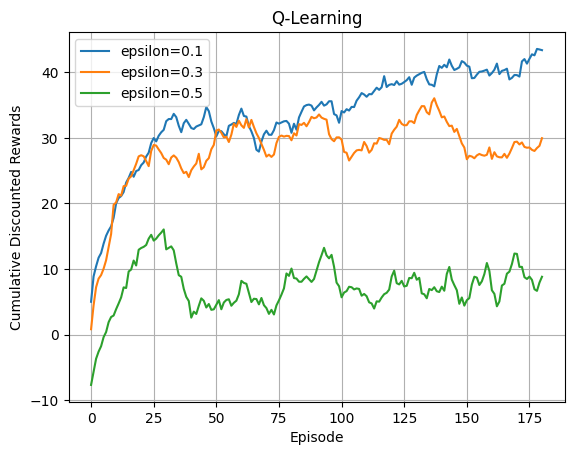

In [137]:
import matplotlib.pyplot as plt
from tqdm import tqdm
trials = 10
epsilons = [.1, .3, .5]
handles_rewards = []
for epsilon in epsilons:
    all_discounted_rewards = []
    print('epsilon: '+ str(epsilon))
    for trial in tqdm(range(trials)):
        [Q,policy,discounted_rewards] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=epsilon)
        all_discounted_rewards.append(discounted_rewards)
    all_discounted_rewards = np.stack(all_discounted_rewards, axis=0)
    all_discounted_rewards = np.mean(all_discounted_rewards, axis=0)
    # Plot the running mean of 20
    running_mean = np.convolve(all_discounted_rewards, np.ones(20)/20, mode='valid')

    handle_rewards, = plt.plot(np.arange(len(running_mean)), running_mean, label='epsilon='+str(epsilon))
    handles_rewards.append(handle_rewards)

plt.grid()
plt.title('Q-Learning')
plt.legend(handles=handles_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Discounted Rewards')
plt.show()

## Impact on cumulative discounted rewards, Q-value, and policy

### Low value of epsilon

A low value of epsilon means that the agent is more likely to stick to its known most optimal actions. This means that the agent is more likely to choose the action with the highest Q value. As a result, the agent will explore less and is more likely to get stuck in a local optima instead of discovering the optimal policy. As a result, in the short run, the cumulative discounted rewards would be higher than if the agent used a higher value of epsilon. Since the agent is less likely to explore and will pick the action that has the highest Q-value, it will have less variance as it is less likely to choose a action that leads to a negative reward. 

### High value of epsilon

An agent that uses a high value of epsilon will explore more, meaning that it is more likely to choose a suboptimal action. This means that in the short run, its cumulative discounted rewards will be lower. However, as it explores more, it might find the optimal action at each state and update its policy to be more optimal than an agent using a lower epsilon. So, in the long run the agent can get close to the agent using lower epsilon values because it found the optimal policy, meaning that will accumulate rewards faster and have larger Q-values. Despite this, the higher variance might make it so that it will never catch up as it might randomly explore and take a suboptimal path, lowing its rewards. 

## Part 2b

Test your code for model-based RL with value iteration on the maze problem 
described above (same maze problem as in Part 1). Produce a graph where 
the x-axis indicates the episode (from 0 to 200) and the y-axis indicates 
the average (based on 20 trials) of the cumulative discounted rewards per 
episode (100 steps). **The graph should contain 1 curve corresponding to 
the exploration probability epsilon=0.1.** The initial state is 0 and the 
initial value function is 0 for all states. Initialize the counts for all 
(s,a,s') to 1 and initialize all average rewards to 0. **How does model-based RL with 
value iteration compare with Q-learning in terms of data efficiency?  Explain.**.

epsilon: 0.1


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


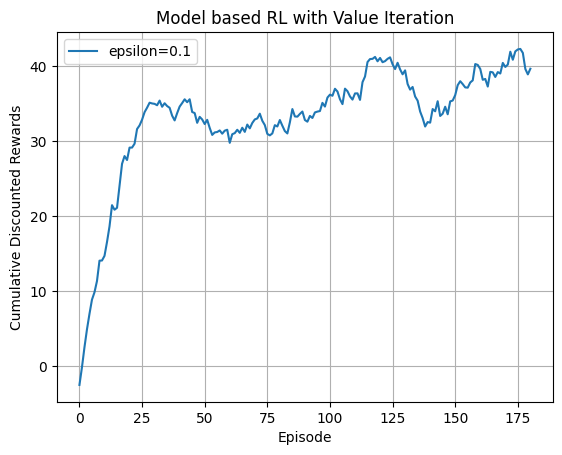

In [145]:
# RL problem
rlProblem = RL(mdp,np.random.normal)

import matplotlib.pyplot as plt
from tqdm import tqdm
trials = 10
epsilon = 0.1
handles_rewards = []
all_discounted_rewards = []
print('epsilon: '+ str(epsilon))
for trial in tqdm(range(trials)):
    [Q,policy,discounted_rewards] = rlProblem.modelBasedRLwithValueIteration(s0=0,initialV=np.zeros([mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=epsilon)
    all_discounted_rewards.append(discounted_rewards)
all_discounted_rewards = np.stack(all_discounted_rewards, axis=0)
all_discounted_rewards = np.mean(all_discounted_rewards, axis=0)
# Plot the running mean of 20 episodes
running_mean = np.convolve(all_discounted_rewards, np.ones(20)/20, mode='valid')

handle_rewards, = plt.plot(np.arange(len(running_mean)), running_mean, label='epsilon='+str(epsilon))
handles_rewards.append(handle_rewards)

plt.grid()
plt.title('Model based RL with Value Iteration')
plt.legend(handles=handles_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Discounted Rewards')
plt.show()

## Data Efficiency 

Model-based RL is more data efficient than Q-learning because it is trying to approximate the model of the environment. This means that after enough iterations, model-based Rl can learn the model and will be able to evaluate future states and actions to create a policy without needing to interact with the environment. On the other hand, Q-learning relies on actual experiences to update the Q values, which in turn is used to update the policy.                          